In [2]:
import numpy as np
import torch
import torch.nn as nn

from torch.autograd import Variable
from pdf_mog import *
from util import train_sgd

%matplotlib inline

data has shape : (10000, 2)


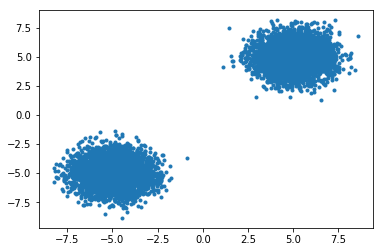

In [3]:
# generate some data from two 2-D Gaussians

samples = 5000

dim = 2
d1 = np.random.multivariate_normal(-5*np.ones(dim), np.eye(dim), samples)
d2 = np.random.multivariate_normal(+5*np.ones(dim), np.eye(dim), samples)
data = np.vstack((d1, d2))

print('data has shape : {}'.format(data.shape))
plt.plot(data[:,0], data[:,1], '.');

In [4]:
dtype = torch.FloatTensor

class MoG(nn.Module):
    def __init__(self, n_components, dim):
        super().__init__()

        self.n_components = n_components
        self.dim = dim
        
        self.softmax = nn.Softmax(dim=0)
        
        self.weights = nn.Parameter(
            torch.ones(n_components).type(dtype))
        self.mus = nn.Parameter(
            torch.Tensor(n_components, dim).random_().type(dtype))
        self.Lvecs = nn.Parameter(
            torch.Tensor(int(n_components*((dim**2+dim)/2))).uniform_(0, 0.1).type(dtype))
    
    def forward(self, X):
        if type(X) == np.ndarray:
            X = torch.from_numpy(X)
        X = Variable(X.type(dtype), requires_grad=False)
        
        # weights
        weights = self.softmax(self.weights)
                
        # covariance factors
        Ls = Variable(torch.zeros(self.n_components, self.dim, self.dim)).type(dtype)
        
        # assign vector to lower triangle of Ls
        (idx1, idx2) = np.tril_indices(self.dim)
        Ls[:, idx1, idx2] = self.Lvecs

        # apply exponential to get positive diagonal
        (idx1, idx2) = np.diag_indices(self.dim)
        Ls[:, idx1, idx2] = torch.exp(Ls[:, idx1, idx2])

        lprobs = multivariate_mog_pdf(X, weights, self.mus, Ls, log=True)
        
        return -torch.mean(lprobs), (weights, self.mus, Ls)

In [6]:
model = MoG(n_components=2, dim=dim)

# initialise at mus and weights to true values
model.mus = nn.Parameter(torch.from_numpy(np.array([[-5,-5],[5,5]])).type(dtype))
model.weights = nn.Parameter(torch.from_numpy(np.array([0.5, 0.5])).type(dtype))
model.Lvecs = nn.Parameter(torch.from_numpy(np.array([0, 0, 0, 0, 0, 0])).type(dtype))

# info
def info(model, data):
    lprobs, (weights, mus, Ls) = model(data)
    
    print('loss {:.3f}'.format(lprobs.data.cpu().numpy()[0]))
    print('')

    for k in range(model.n_components):
        L = Ls[k,:,:].data.numpy()
        cov = np.dot(L, L.T)

        print('component {}'.format(k))
        print('weight : {}'.format(weights[k].data.cpu().numpy()))
        print('mu : {}'.format(mus[k,:].data.cpu().numpy()))
        print('cov : {}'.format(cov))
        print('')

info(model, data)

loss 3.518

component 0
weight : [0.5]
mu : [-5. -5.]
cov : [[1. 0.]
 [0. 1.]]

component 1
weight : [0.5]
mu : [5. 5.]
cov : [[1. 0.]
 [0. 1.]]



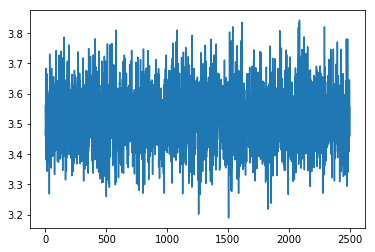

In [7]:
losses = train_sgd(list(data), model, n_epochs=25, n_minibatch=100)

plt.plot(losses);

In [9]:
info(model, data)

loss 3.518

component 0
weight : [0.49912092]
mu : [-5.000378 -5.005606]
cov : [[ 0.99487877 -0.01180077]
 [-0.01180077  0.9740873 ]]

component 1
weight : [0.50087905]
mu : [5.015678 5.010956]
cov : [[1.0003605  0.00330733]
 [0.00330733 0.9939854 ]]

